<a href="https://colab.research.google.com/github/XuRui314/MIT_6.036_homework_zxr/blob/main/%E6%A8%A1%E5%BC%8F%E8%AF%86%E5%88%AB%E4%BD%9C%E4%B8%9A%E4%B8%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第一次

## 问题一
1. $x_1, x_2, \ldots, x_N$ 是 $d$ 维样本, $\Sigma$ 是一个 $d \times d$ 正定矩阵, 证明使
$$
\sum_{k=1}^N\left(x_k-x\right)^T \Sigma^{-1}\left(x_k-x\right)
$$
最小的向量 $x$ 是样本的均值 $\mu=\frac{1}{N} \sum_{i=1}^N x_i$ 。




**证明**： 首先你要知道这个是成立的
$$
\frac{dx^TAx}{dx}=2Ax
$$
是这样推的：
$$
\begin{aligned}
	d\left( {x}^TA{x} \right) &=\left( {x}^TA \right) d{x}+d\left( {x}^TA \right) {x}\\
	&={x}^TAd{x}+{x}^Td\left( A^T{x} \right)\\
	&={x}^TAd{x}+{x}^TA^Td{x}\\
	&={x}^T\left( A+A^T \right) d{x}\\
	&=2{x}^TAd{x}\\
\end{aligned}
$$

其中 $A$ 是正定矩阵, 对于本题, 由于 $\Sigma$ 是正定矩阵, 因此 $\Sigma^{-1}$ 也是正定矩阵 (证明略)。 可以构造 $z_1, \ldots z_n$ 这 $n$ 个向量, 定义为:
$$
z_i=x_i-x
$$
则原式:
$$
\sum_{k=1}^N\left(x_k-x\right)^T \Sigma^{-1}\left(x_k-x\right)
$$
可以转换为:
$$
\sum_{k=1}^N z_k{ }^T \Sigma^{-1} z_k k
$$
对 $x$ 向量进行求梯度, 可以得到表达式:
$$
2 \Sigma^{-1} \sum_{k=1}^N z_k
$$
令此表达式为 0 向量, 可以得到 $x$ 的表达式:
$$
x=\mu=\frac{1}{N} \sum_{i=1}^N x_i 
$$

## 问题二
2. 8个二维矢量, 前四个属于一个类别, 后四个属于另外一个类别:
$$
\begin{gathered}
\omega_1: x_1=(4,-2)^T, x_2=(3,-1)^T, x_3=(3,-3)^T, x_4=(3,-2)^T \\
\omega_2: x_5=(3,0)^T, x_6=(3,-4)^T, x_7=(1,-2)^T, x_8=(0,-1)^T
\end{gathered}
$$
(1) 请用最近邻分类方法判别 $x=(0,0)^T$ 的类别属性。
(2) 画出最近邻法分类界面。
(3) 采用单模板匹配的方法判别 $x$ 的类别属性, 并画出相应的分类界面。

最近邻判别就是计算得到最近（默认是欧式）的那个点的类别，这里写个for循环吧：

Voronoi图参考资料：https://ipython-books.github.io/145-computing-the-voronoi-diagram-of-a-set-of-points/

In [ ]:
pip install smopy

In [7]:
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
import smopy
%matplotlib inline


In [4]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


(-4.1, 0.1)

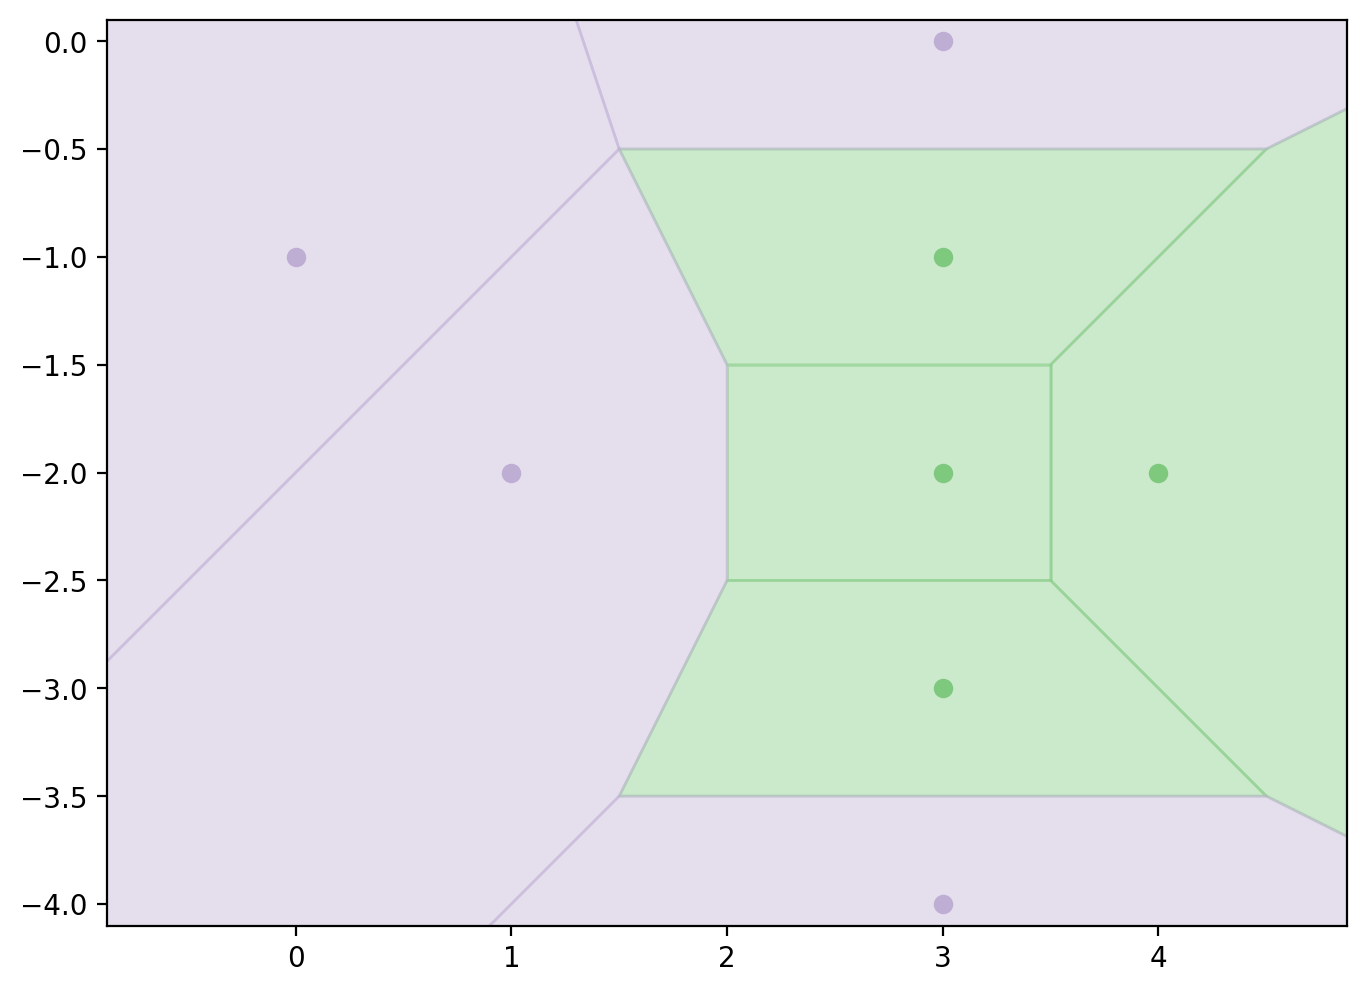

In [56]:
# make up data points)

points = np.array([[4,3,3,3,3,3,1,0],
    [-2,-1,-3,-2,0,-4,-2,-1]]).transpose(1,0)

types = [0,0,0,0,1,1,1,1]

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
plt.figure(figsize=(8,6),dpi=200)

regions, vertices = voronoi_finite_polygons_2d(vor)

# 设置颜色循环
region_colors = plt.cm.get_cmap("Accent").colors

# colorize
for i,region in enumerate(regions):
    polygon = vertices[region]
    plt.fill(*zip(*polygon), color=region_colors[types[i]],alpha=0.4)

for i,point in enumerate(points):
    plt.plot(point[0], point[1], 'ko', color = region_colors[types[i]])

plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)


## 问题三
3. 分别采用顺序聚类, 谱系聚类和 $\mathrm{K}$-均值聚类算法将下列 8 个样本聚成两个类 别, 并用 Dunn 指数和 Davies-Bouldin 指数评估聚类效果。
$$
\begin{gathered}
x_1=(5,2)^T, x_2=(1,2)^T, x_3=(2,1)^T, x_4=(6,2)^T \\
x_5=(1,1)^T, x_6=(3,1)^T, x_7=(7,-1)^T, x_8=(5,-1)^T
\end{gathered}
$$

聚类评价理论参考文章：

https://www.biaodianfu.com/cluster-score.html

https://blog.csdn.net/u010986753/article/details/97885955


### K-Means

In [7]:
from sklearn.cluster import KMeans

data = np.array([[5,1,2,6,1,3,7,5],[2,2,1,2,1,1,-1,-1]]).transpose(1,0)
kmeans_model = KMeans(n_clusters = 2, init = 'k-means++').fit(data)


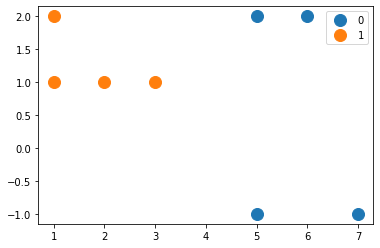

In [9]:
import matplotlib.pyplot as plt
# 对于分组变量的处理

import pandas as pd

labels = kmeans_model.labels_
#create DataFrame
df = pd.DataFrame({'x': data[:,0],
                   'y': data[:,1],
                   'z': labels})

groups = df.groupby('z')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.legend()

这个是肘型线，可以看出，选择两个聚类是合理的。

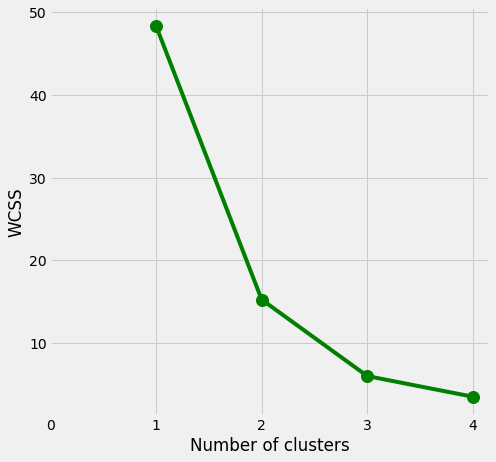

In [22]:
# find the optimal number of clusters using elbow method
from sklearn.cluster import KMeans

WCSS = []
for i in range(1,5):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(data)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,5),WCSS, linewidth=4, markersize=12,marker='o',color = 'green')
plt.xticks(np.arange(5))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

轮廓系数可视化：

In [10]:

def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10


    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  


<Figure size 2400x1600 with 0 Axes>

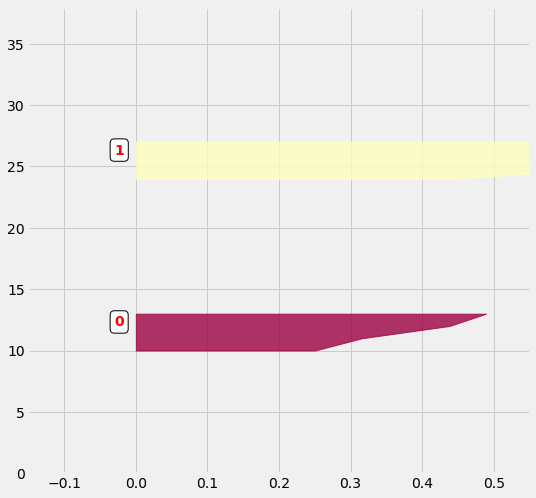

In [14]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib as mpl

scaled_matrix = data
clusters_clients = labels
n_clusters = 2

sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
plt.figure(figsize=(12,8),dpi=200)
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)


计算Dunn 指数和 Davies-Bouldin 指数：

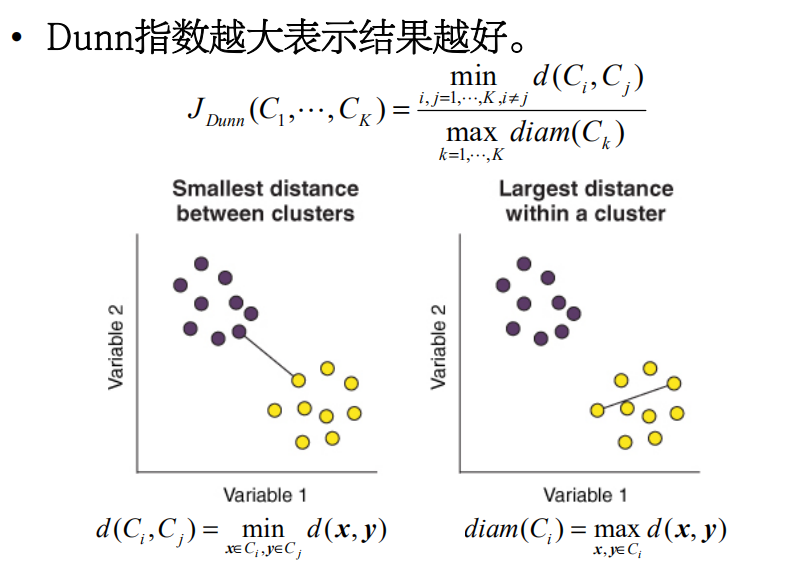

In [ ]:
!git clone https://github.com/jqmviegas/jqm_cvi jqmcvi

In [48]:
import sys
sys.path.append('jqmcvi')

In [53]:
import pandas as pd 
from sklearn import datasets 
from jqmcvi.jqmcvi import base
# loading the dataset 
X = data
df = pd.DataFrame(X) 
# K-Means 
from sklearn import cluster 
k_means = cluster.KMeans(n_clusters=2) 
k_means.fit(df) #K-means training 
y_pred = k_means.predict(df) 
# We store the K-means results in a dataframe 
pred = pd.DataFrame(y_pred) 
pred.columns = ['Type'] 
# we merge this dataframe with df 
prediction = pd.concat([df, pred], axis = 1) 
# We store the clusters 
clus0 = prediction.loc[labels == 0] 
clus1 = prediction.loc[labels == 1] 

cluster_list = [clus0.values, clus1.values] 
print(base.dunn(cluster_list))

0.6793662204867574


In [15]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(data, labels)

0.6331473961991908

### 顺序聚类

### 谱聚类

## 问题四
4. 根据下列 3 组高斯分布参数分别生成 200 个 2 维随机样本, 使用 K-均值算法 将所有样本聚成若干类别, 采用类内距离准则确定合理聚类数。
$$
\begin{gathered}
\mu_1=(-1,-1)^T, \mu_2=(6,2)^T, \mu_3=(0.5,7)^T \\
\Sigma_1=\left[\begin{array}{cc}
1 & 0.5 \\
0.5 & 1
\end{array}\right], \Sigma_2=\left[\begin{array}{cc}
1 & 0 \\
0 & 1
\end{array}\right], \Sigma_3=\left[\begin{array}{cc}
1 & -0.5 \\
-0.5 & 1
\end{array}\right]
\end{gathered}
$$

In [62]:
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import numpy as np
N, mean, cov = 200, np.array([-1,1]), np.array([[1,0.5],[0.5,1]])
data1 = np.random.multivariate_normal(mean, cov, N)
data1 = pd.DataFrame(data=data1, columns = ['x','y'])

N, mean, cov = 200, np.array([6,2]), np.array([[1,0],[0,1]])
data2 = np.random.multivariate_normal(mean, cov, N)
data2 = pd.DataFrame(data=data2, columns = ['x','y'])

N, mean, cov = 200, np.array([0.5,7]), np.array([[1,-0.5],[-0.5,1]])
data3 = np.random.multivariate_normal(mean, cov, N)
data3 = pd.DataFrame(data=data3, columns = ['x','y'])


三个聚类的可视化：

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Se

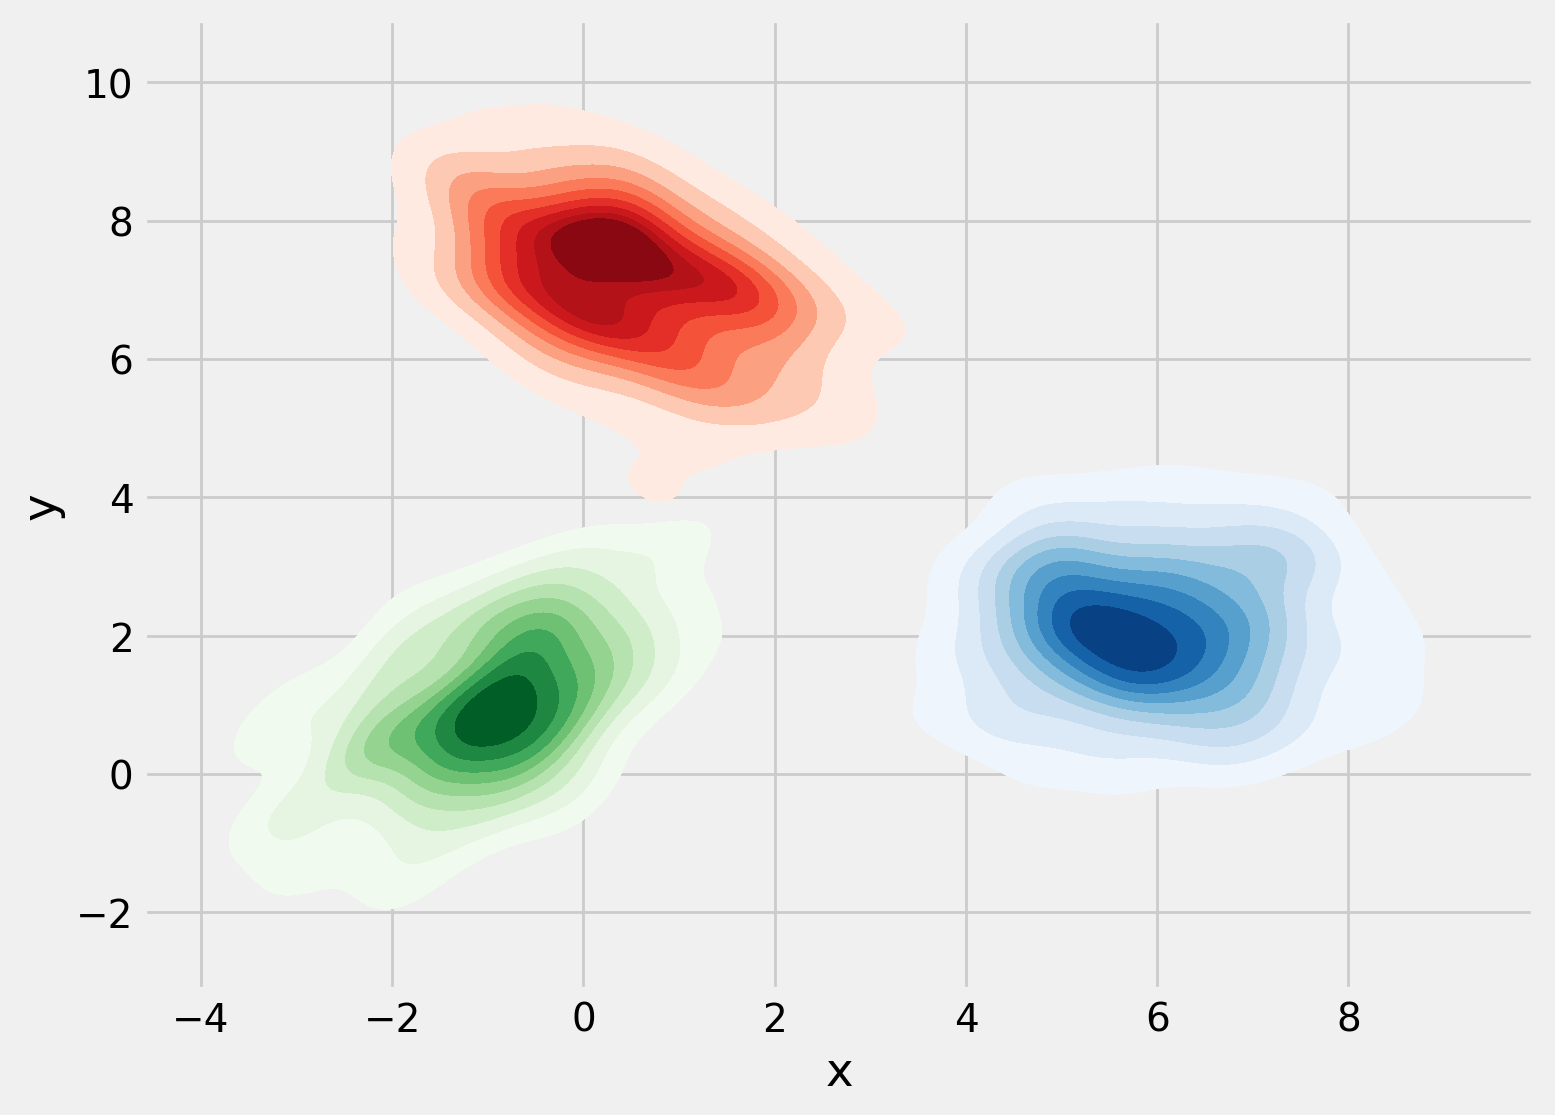

In [68]:
plt.figure(figsize=(8,6),dpi=200)

sns.kdeplot(data1['x'],data1['y'],cmap = 'Greens',
            shade = True,shade_lowest=False)
sns.kdeplot(data2['x'],data2['y'],cmap = 'Blues',
            shade = True,shade_lowest=False)
sns.kdeplot(data3['x'],data3['y'],cmap = 'Reds',
            shade = True,shade_lowest=False)


## 问题五
5. 利用拉格朗日乘子法推导模糊 C 均值的最优解。

## 问题六
6. 查阅资源，深入理解和讨论 L1 和 L2 范数的区别（数学表达、优
化求解、优点和缺点、应用范围等）。